In [52]:
import torch
import networkx as nx
from matplotlib import pyplot as plt
device =  "cpu"

def Population(n:int, device= "cpu"):
  initial_population = { #a columnar DB somewhat reminds the Pandas DataFrame 
      "I":torch.zeros(n).to(device),
      "susceptiveness":torch.ones(n).to(device).requires_grad_(True)*1.0,
      "infectiveness":torch.ones(n).to(device).requires_grad_(True)*1.0
  }
  initial_population["I"][0]=1 #first one infective
  return initial_population

class SI_dense(torch.nn.Module):
    """
    Stochastic individual base (S)usceptible-(I)nfective transition. 
    The infective agent propagates through an unweighted contact network 
    stored as a dense Tensor.     
    """
    def __init__(self, contact_net, pinf, I_name, susceptiveness_name, infectiveness_name, device, start=0):
        super(SI_dense,self).__init__()
        self._contact_net = contact_net
        self._pinf = torch.nn.parameter.Parameter(torch.Tensor([pinf]).to(device)) # set it as trainnable
        self._n = contact_net.size()[0]
        self._t = 0
        self._start = start
        self._states_names = {'I': I_name, 'susceptiveness': susceptiveness_name, 'infectiveness': infectiveness_name}
        
    def forward(self, states):
        self._t+=1
        if self._t >= self._start:
            I = states[self._states_names['I']] # boolean state of being infected
            susceptiveness = states[self._states_names['susceptiveness']] # floating point, number between 0 and 1 means probability of being infected
            infectiveness = states[self._states_names['infectiveness']] # floating point, number between 0 and 1 means probability of infecting another
    
            susceptible = (I==0).float()
            susceptible*=susceptiveness
            susceptible = susceptible.unsqueeze(dim=1)
            infective=infectiveness*I
            infective=infective*self._pinf
            infective = infective.unsqueeze(dim=0)

            con = self._contact_net*infective*susceptible#n*n, 1*n (row multiply), n*1 (column multiply)
            #why do like this?
            con = torch.log(1 - con)     
            dI = 1 - torch.exp(con.mm(torch.ones(self._n).to(device).unsqueeze(dim=1)).squeeze()) # probability of being infected that day
            #print(dI)
            dIsample= torch.rand(self._n).to(device)

            #dI = torch.rand(self._n, requires_grad=True).to(device) < dI 
            #random will effect the result, less than operation will lose gradient
            dI_01= dI>dIsample

            dI= dI*(1-I)
            

            I = torch.max(I, dI_01) # got infected

            states[self._states_names['I']] = I

        return states, dI
    
    def ODE(self, time_horizon, degree):
        ODEIs= [1]
        ODEI= 1
        ODES= self._n - ODEI
        dI= 1
        Cvalue= 0
        for i in range(time_horizon):
            #dI= (self._pinf.item()*degree*ODEI*ODES)/(self._n), outer link number
            if i!=0:
                 Cvalue= dI*(degree-1)*(ODES)/(ODES+ODEI-1)+Cvalue*(1-self._pinf.item())*ODES/(ODES+dI-1+1e-8)# nongenerative edge+cross edges
            else:
                 Cvalue= ODEI*degree
            dI= Cvalue*self._pinf.item()
            #dI= self._pinf.item()*ODEI*degree*ODES/self._n
            ODEI+= dI#(generative edges + nongenerative edge)= inner edge, cross edges, outer edge
            ODES-= dI
            if ODES< 0:
                ODES= 0
                ODEI= self._n
            ODEIs.append(ODEI)
        return torch.tensor(ODEIs).to(device)
def sim(time_horizon, population, model, mode="run"):
  log = [population['I']]
  IMeans = [torch.tensor(0).to(device)]
  for i in range(time_horizon):
    population, dI = model(population)
    log.append(population['I'])
    IMeans.append(dI.sum()+IMeans[-1])
  log = torch.stack(log)
  IMeans = torch.stack(IMeans)
  log = log.unsqueeze(dim=1)
  log = log.unsqueeze(dim=0)
  return log, IMeans

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
tensor([  1.0000,   2.4667,   6.2667,  15.7333,  37.8333,  88.3000, 191.0667,
        359.3000, 565.8333, 753.3666, 872.7000, 938.5333, 970.9333, 986.2000,
        993.4667])
tensor([   1.0000,    2.6000,    6.1156,   13.8178,   30.5825,   66.5552,
         141.3511,  286.4550,  528.1321,  815.9839,  980.2097,  998.9711,
         999.8200, 1000.0000, 1000.0000])


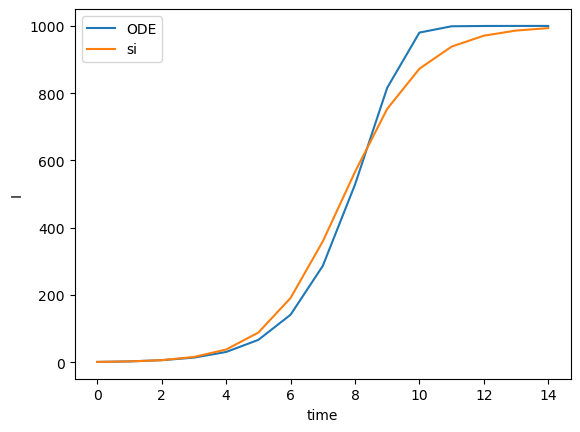

In [51]:
time_horizon=14
pinf= 0.2
n= 1000
avgDegree= 4
times= 30
stats_gt_si_avg=torch.zeros(time_horizon+1)
for i in range(times):
    print(i)
    graph=nx.dense_gnm_random_graph(n, n*avgDegree)
    graph=nx.to_numpy_array(graph)
    contacts = torch.FloatTensor(graph)
    contacts = contacts.requires_grad_(True)

    si =     SI_dense(contacts, pinf=pinf, I_name="I",susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness", device=device)
    with torch.no_grad():
        population = Population(n, device=device)
        si_result, _ = sim(time_horizon, population, si, mode="run")
    stats_gt   = si_result.sum(dim=3) # si along 20 iterations
    stats_gt_si_avg+= stats_gt.squeeze()
stats_gt_si_avg/=times
stats_gt= si.ODE(time_horizon, avgDegree*2)

plt.plot(stats_gt, label='ODE')
plt.plot(stats_gt_si_avg, label='si')
plt.xlabel("time")
plt.ylabel("I")
plt.legend()
print(stats_gt_si_avg)
print(stats_gt)

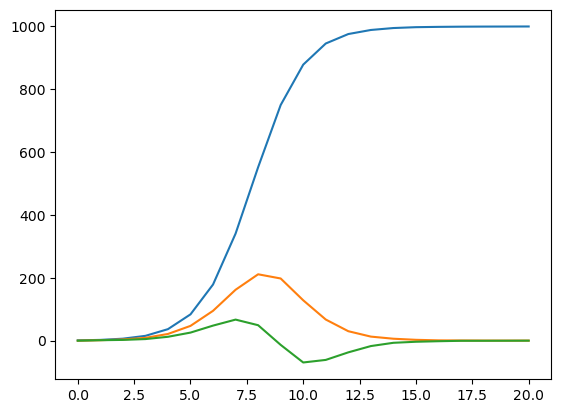

In [59]:
datas=[1.0000,   2.4600,   6.3500,  15.3200,  36.6600,  83.6900, 178.6400,
        340.5900, 551.7200, 749.4800, 877.8900, 945.1200, 975.2000, 988.1300,
        994.3000, 997.0200, 998.0200, 998.6200, 998.9100, 999.0600, 999.2500]
dIs=[0]
for i in range(1, len(datas)):
    dIs.append(datas[i]-datas[i-1])
dIIs=[0]
for i in range(1, len(dIs)):
    dIIs.append(dIs[i]-dIs[i-1])
plt.plot(datas, label='data')
plt.plot(dIs, label='dI')
plt.plot(dIIs, label='dI')

tensor([  1.0000,   2.4600,   6.3500,  15.3200,  36.6600,  83.6900, 178.6400,
        340.5900, 551.7200, 749.4800, 877.8900, 945.1200, 975.2000, 988.1300,
        994.3000, 997.0200, 998.0200, 998.6200, 998.9100, 999.0600, 999.2500])
tensor([  1.0000,   2.6000,   6.1121,  13.7989,  30.5136,  66.3454, 140.7877,
        285.1396, 525.6876, 813.1041, 978.9097, 998.7736, 999.7318, 999.8998,
        999.9500, 999.9701, 999.9797, 999.9849, 999.9880, 999.9900, 999.9913])


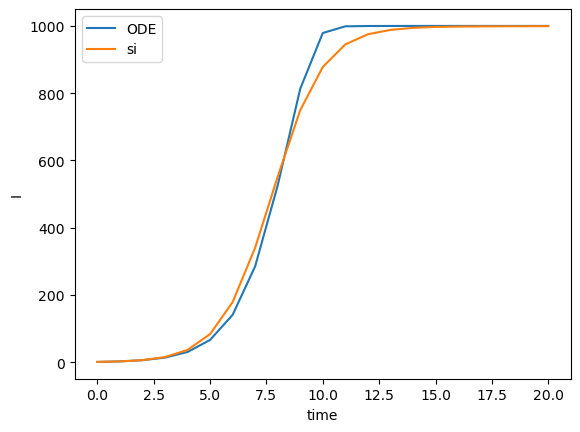

In [39]:
datas=[1.0000,   2.5567,   6.3867,  15.5700,  36.8233,  84.0100, 179.5133,
        344.1833, 560.0600, 756.3766, 881.4400, 945.1633, 974.0600, 986.9533,
        993.3367]
dIs=[]
for i in range(1, len(datas)):
    dIs.append(datas[i]-datas[i-1])
print(dIs)

